## Install and import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras 
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [2]:
IMG_SIZE = (299, 299) # resolution
directory = "../input/zeytin-yaprak-224-aug/Zeytin_224x224_Augmented/train"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)


Found 5011 files belonging to 3 classes.
Using 4510 files for training.
Found 5011 files belonging to 3 classes.
Using 501 files for validation.


In [3]:
class_names = train_dataset.class_names
class_names

['Kus_Gozu_Mantari', 'Pas_Akari', 'Saglikli']

In [5]:
class_names = train_dataset.class_names
print("Original class names:", class_names)

# Reassign class names to new values
class_names = ["Cycloconium_oleaginum", "rust_mite", "Helthy"]

# Verify the updated class names
print("Updated class names:", class_names)

Original class names: ['Kus_Gozu_Mantari', 'Pas_Akari', 'Saglikli']
Updated class names: ['Cycloconium_oleaginum', 'rust_mite', 'Helthy']


## Data imbalance


#### 1- Resampling

#### 2- Class Weights :
 The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, 
 so you would want to have the classifier heavily weight the few examples that are available. 
 You can do this by passing Keras weights for each class through a parameter.
 These will cause the model to "pay more attention" to examples from an under-represented class

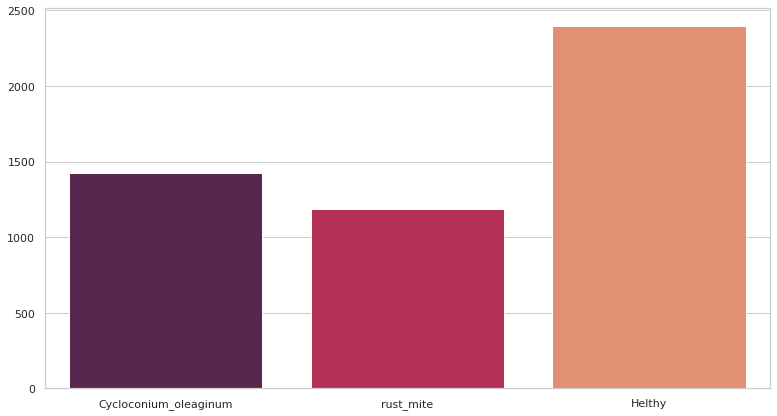

In [6]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Cycloconium_oleaginum","rust_mite","Helthy"], y=Data_imbalance, palette="rocket")
plt.show()

In [7]:
total = 0 
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i] 
    
weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))


Weight for class 0: 0.88
Weight for class 1: 1.05
Weight for class 2: 0.52


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

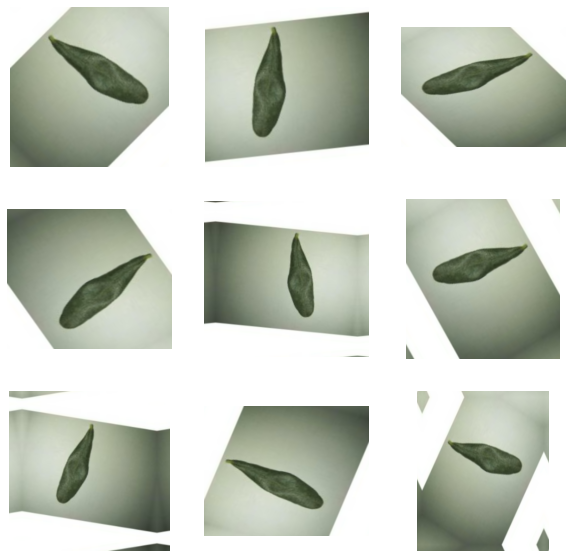

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

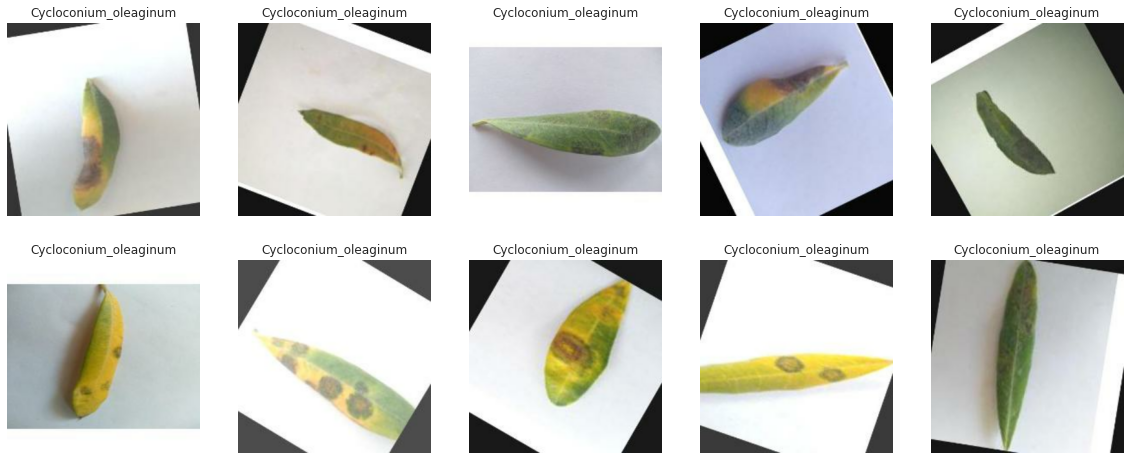

In [11]:
plt.figure(figsize=(20,8))
Cycloconium_oleaginum = []
rust_mite = []
Helthy =[]
for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Cycloconium_oleaginum":
            Cycloconium_oleaginum.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "rust_mite":   
            rust_mite.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Helthy":   
            Helthy.append(images[i].numpy().astype("uint8"))  
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Cycloconium_oleaginum[i])
    plt.axis("off")
    plt.title("Cycloconium_oleaginum")

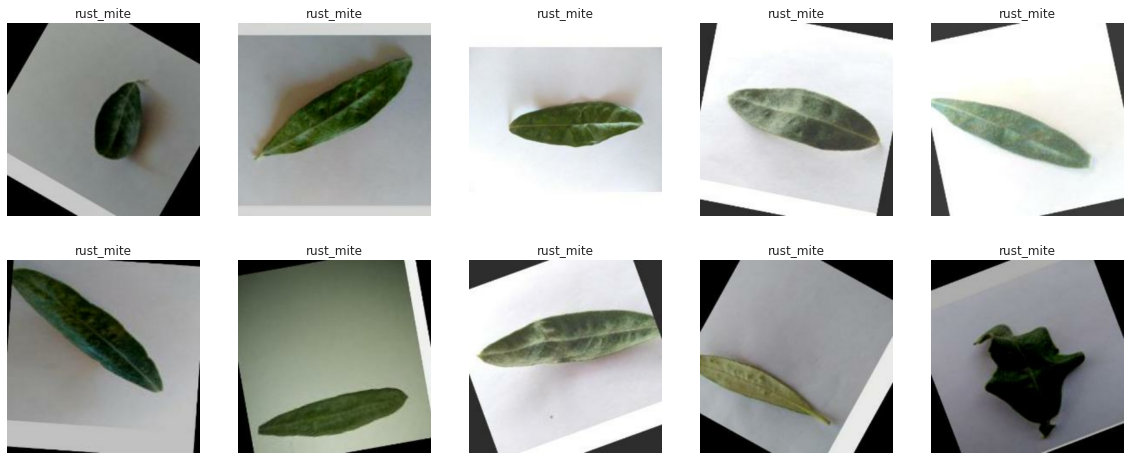

In [12]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(rust_mite[i])
    plt.axis("off")
    plt.title("rust_mite")

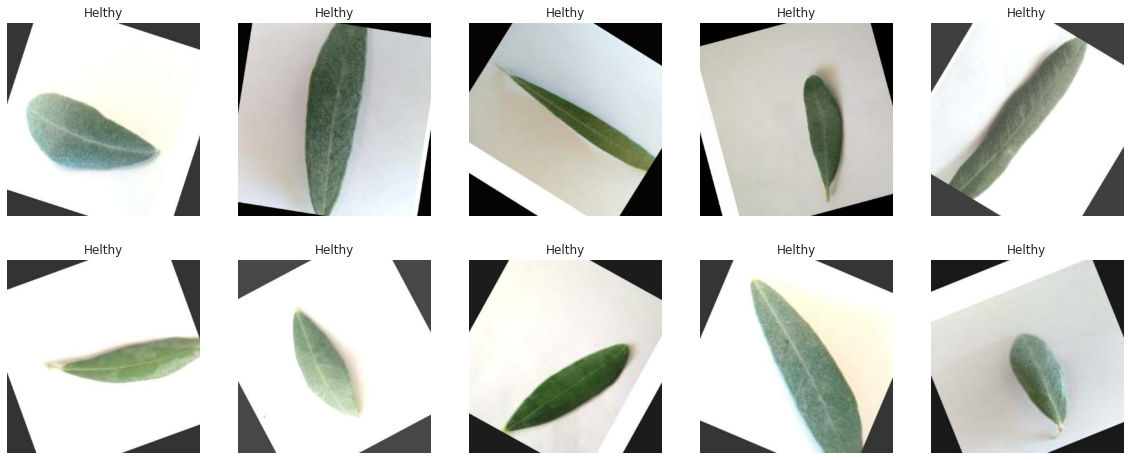

In [13]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Helthy[i])
    plt.axis("off")
    plt.title("Helthy")

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Modeling


### Preparing the ground <a id="3.1"></a>
​
Before we move on to building the models, I will explain the major building blocks in pretrained CV models. Every major ImageNet model has a different architecture, but each one has the common building blocks: **Conv2D, MaxPool, ReLU**. I have already explained the mechanism behind convolution in the previous section, so I will now explain MaxPool and ReLU.
<br></br>
### Pooling Layer
​
<center><img src="https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif" width="400px"></center>
<br></br>
Similar to the Convolutional Layer, the Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model <br></br>


There are two types of Pooling: Max Pooling and Average Pooling. Max Pooling returns the maximum value from the portion of the image covered by the Kernel. On the other hand, Average Pooling returns the average of all the values from the portion of the image covered by the Kernel.


Max Pooling also performs as a Noise Suppressant. It discards the noisy activations altogether and also performs de-noising along with dimensionality reduction. On the other hand, Average Pooling simply performs dimensionality reduction as a noise suppressing mechanism. Hence, we can say that Max Pooling performs a lot better than Average Pooling.

​
<center><img src="https://miro.medium.com/max/1192/1*KQIEqhxzICU7thjaQBfPBQ.png" width="400px"></center>
<br></br>

### Convolutional layer:

The main objective of convolution is to extract features such as edges, colours, corners from the input. As we go deeper inside the network, the network starts identifying more complex features such as shapes,digits, face parts as well.
<center><img src="https://miro.medium.com/max/1052/1*Fp7EhLmTtPxJTjmjy_DspQ.gif" width="400px"></center>

### Relu 

ReLU is the most commonly used activation function in neural networks, especially in CNNs. If you are unsure what activation function to use in your network, ReLU is usually a good first choice.

ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x). Visually, it looks like the following:
<center><img src="https://miro.medium.com/max/1400/1*DfMRHwxY1gyyDmrIAd-gjQ.png" width="400px"></center>


In [15]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [16]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [17]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 311
activation_93
mixed10


In [18]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


# Inception v3 (2015)
Inception v3 mainly focuses on burning less computational power by modifying the previous Inception architectures. This idea was proposed in the paper Rethinking the Inception Architecture for Computer Vision, published in 2015. It was co-authored by Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, and Jonathon Shlens.

In comparison to VGGNet, Inception Networks (GoogLeNet/Inception v1) have proved to be more computationally efficient, both in terms of the number of parameters generated by the network and the economical cost incurred (memory and other resources).

If any changes are to be made to an Inception Network, care needs to be taken to make sure that the computational advantages aren’t lost.
Thus, the adaptation of an Inception network for different use cases turns out to be a problem due to the uncertainty of the new network’s efficiency. In an Inception v3 model, several techniques for optimizing the network have been put suggested to loosen the constraints for easier model adaptation. The techniques include factorized convolutions, regularization, dimension reduction, and parallelized computations.


<br>
<center> <img   width="800"  src="https://lh3.googleusercontent.com/bA_Rkj4a0sA3NZ1wjUYIO5_eq0hUmiBNbagOFb84C8Y9GxeedGUYNd-LIbhAlpW-1o8xSeNypMnbD6p-XsrAQvup3FeWXrAoZig7l7Y9WIK3uDHooEMEKiNNQ2qt0PfA4Zfsyltn" alt="Alternative text" /> </center>

In [ ]:
def plant_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    inception_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    inception_model.trainable = True
    for layer in inception_model.layers[0 : 291]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = inception_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax") 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model

In [20]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196  

# Compiling the model 
Following this, you have to compile our model. You need to use an Adam optimizer to optimize your model and a loss function to calculate the loss. The metrics define which metric you want to calculate. In this case, it is accuracy.

In [21]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

# Training our model
After compiling, fit the model to your training data, ie: train the model. You will train it in batch sizes of 128 with 10 epochs and use 20% of the data as the validation set.

In [22]:
history = Plant_Leaf_Model.fit(train_dataset , verbose=2 , epochs=25 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True)


Epoch 1/25
36/36 - 40s - loss: 0.9288 - accuracy: 0.7047 - val_loss: 0.3100 - val_accuracy: 0.8882
Epoch 2/25
36/36 - 26s - loss: 0.1962 - accuracy: 0.9111 - val_loss: 0.4607 - val_accuracy: 0.8124
Epoch 3/25
36/36 - 26s - loss: 0.1346 - accuracy: 0.9386 - val_loss: 0.1830 - val_accuracy: 0.9222
Epoch 4/25
36/36 - 25s - loss: 0.0820 - accuracy: 0.9654 - val_loss: 0.1717 - val_accuracy: 0.9321
Epoch 5/25
36/36 - 26s - loss: 0.0560 - accuracy: 0.9763 - val_loss: 0.1483 - val_accuracy: 0.9461
Epoch 6/25
36/36 - 26s - loss: 0.1301 - accuracy: 0.9632 - val_loss: 0.1276 - val_accuracy: 0.9441
Epoch 7/25
36/36 - 25s - loss: 0.0383 - accuracy: 0.9878 - val_loss: 0.1170 - val_accuracy: 0.9501
Epoch 8/25
36/36 - 26s - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.1296 - val_accuracy: 0.9541
Epoch 9/25
36/36 - 26s - loss: 0.0303 - accuracy: 0.9876 - val_loss: 0.1028 - val_accuracy: 0.9681
Epoch 10/25
36/36 - 26s - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.1139 - val_accuracy: 0.9641
Epoch 11/

In [23]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

4/4 [==============================] - 3s 613ms/step - loss: 0.1157 - accuracy: 0.9641


[0.11574582010507584, 0.9640718698501587]

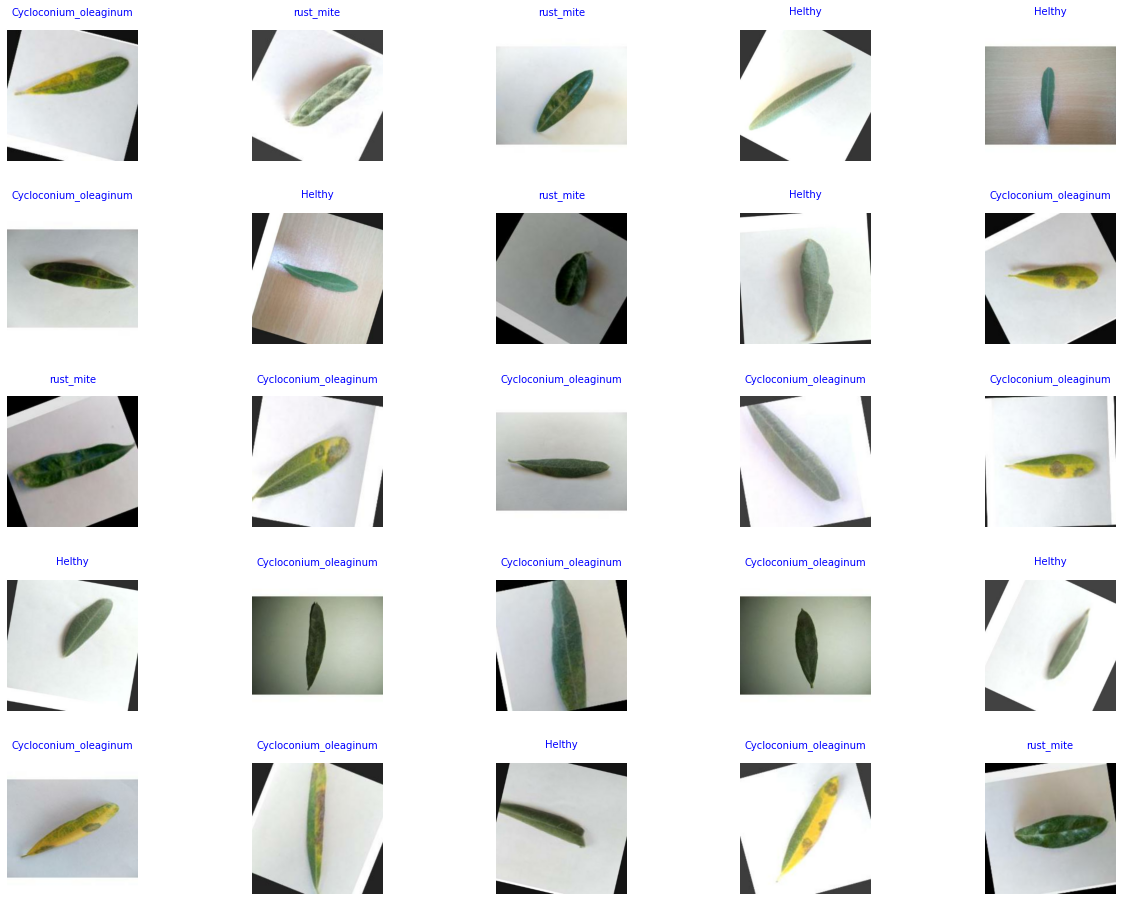

In [24]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);  
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                            top=0.9, wspace=0.4,hspace=0.4)    

# Plotting Accuracy

A convolutional neural network can be evaluated using the ‘evaluate’ method. This method takes the test data as its parameters. Before this, the data is plotted on the console using ‘matplotlib’ library and ‘imshow’ methods.

Convolutional neural networks have been used to produce great results for a specific kind of problems, such as image recognition.  

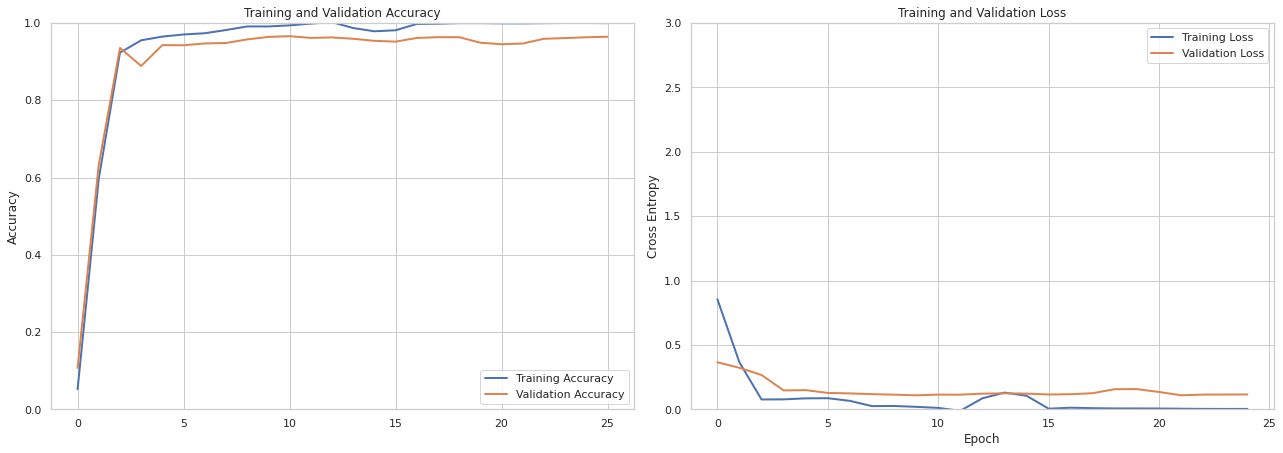

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Original data
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Smooth the curves
acc_smooth = savgol_filter(acc, window_length=5, polyorder=2)
val_acc_smooth = savgol_filter(val_acc, window_length=5, polyorder=2)
loss_smooth = savgol_filter(loss, window_length=5, polyorder=2)
val_loss_smooth = savgol_filter(val_loss, window_length=5, polyorder=2)

# Plotting
plt.figure(figsize=(18, 12))

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(acc_smooth, label='Training Accuracy', linewidth=2)
plt.plot(val_acc_smooth, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(loss_smooth, label='Training Loss', linewidth=2)
plt.plot(val_loss_smooth, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()


In [27]:
Plant_Leaf_Model.save('Model.h5')

In [28]:
# use the model  after save as h5 
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/Model.h5')

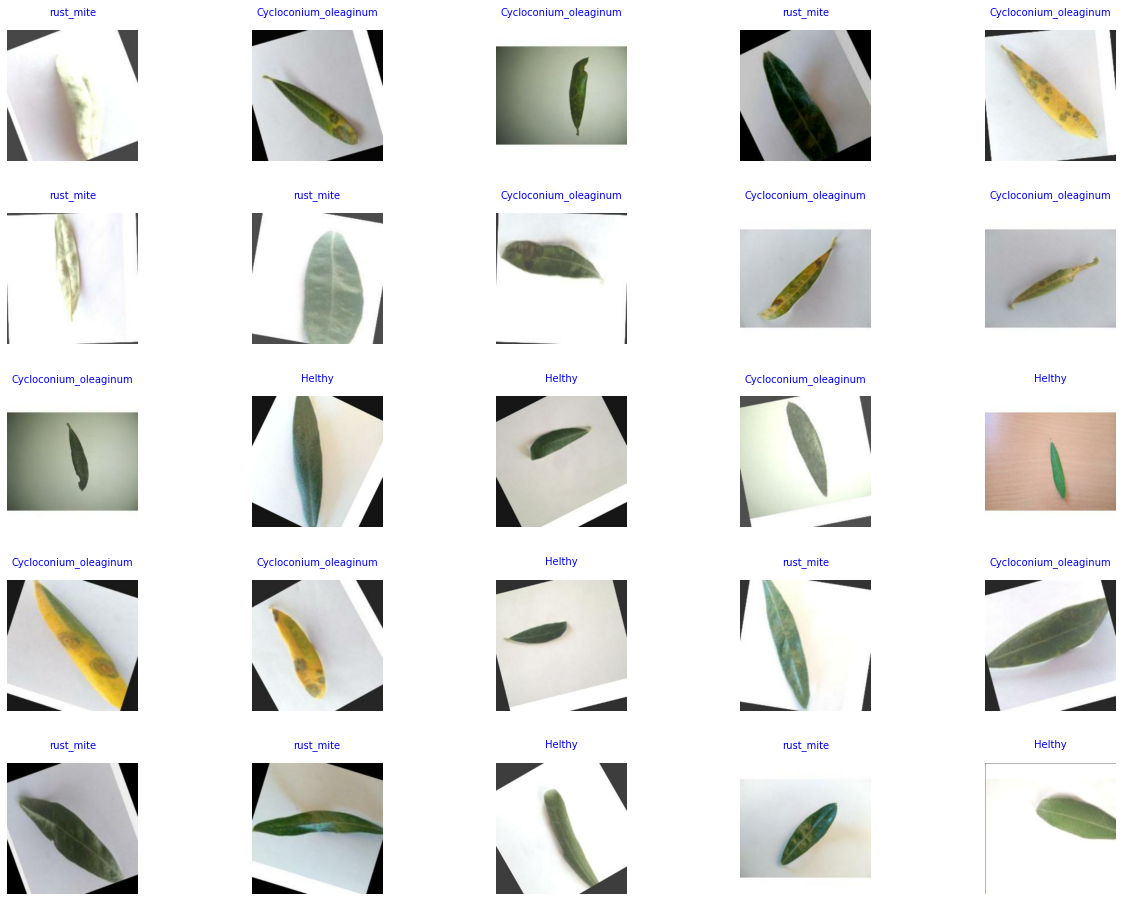

In [29]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);  
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                            top=0.9, wspace=0.4,hspace=0.4)   

# **Cnn**

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Build a basic CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile the CNN
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the CNN
history_cnn = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25,
    class_weight=class_weight
)


Epoch 1/25
36/36 [==============================] - 24s 489ms/step - loss: 156.6715 - accuracy: 0.4807 - val_loss: 0.9815 - val_accuracy: 0.5309
Epoch 2/25
36/36 [==============================] - 15s 376ms/step - loss: 0.6415 - accuracy: 0.5878 - val_loss: 0.8332 - val_accuracy: 0.5968
Epoch 3/25
36/36 [==============================] - 15s 378ms/step - loss: 0.5563 - accuracy: 0.6534 - val_loss: 0.7487 - val_accuracy: 0.6507
Epoch 4/25
36/36 [==============================] - 14s 369ms/step - loss: 0.5303 - accuracy: 0.6918 - val_loss: 0.5926 - val_accuracy: 0.7405
Epoch 5/25
36/36 [==============================] - 14s 370ms/step - loss: 0.4622 - accuracy: 0.7419 - val_loss: 0.5512 - val_accuracy: 0.7685
Epoch 6/25
36/36 [==============================] - 14s 366ms/step - loss: 0.3564 - accuracy: 0.8104 - val_loss: 0.4434 - val_accuracy: 0.8004
Epoch 7/25
36/36 [==============================] - 14s 368ms/step - loss: 0.3186 - accuracy: 0.8275 - val_loss: 0.4718 - val_accuracy: 0.76

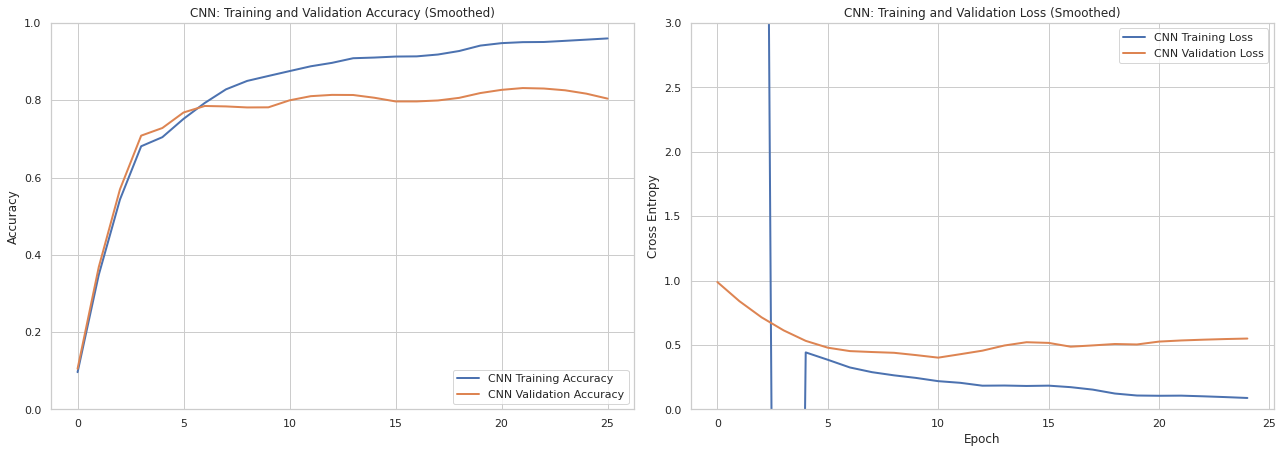

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# CNN History
acc_cnn = [0.] + history_cnn.history['accuracy']
val_acc_cnn = [0.] + history_cnn.history['val_accuracy']
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

# Smooth the curves
acc_smooth_cnn = savgol_filter(acc_cnn, window_length=7, polyorder=2)
val_acc_smooth_cnn = savgol_filter(val_acc_cnn, window_length=7, polyorder=2)
loss_smooth_cnn = savgol_filter(loss_cnn, window_length=7, polyorder=2)
val_loss_smooth_cnn = savgol_filter(val_loss_cnn, window_length=7, polyorder=2)

# Plotting
plt.figure(figsize=(18, 12))

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(acc_smooth_cnn, label='CNN Training Accuracy', linewidth=2)
plt.plot(val_acc_smooth_cnn, label='CNN Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('CNN: Training and Validation Accuracy (Smoothed)')

# Plot Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(loss_smooth_cnn, label='CNN Training Loss', linewidth=2)
plt.plot(val_loss_smooth_cnn, label='CNN Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('CNN: Training and Validation Loss (Smoothed)')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()


# **EfficientNetB0 Model**

In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load EfficientNetB0 base
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Freeze most of the layers
for layer in efficientnet_base.layers[:-10]:
    layer.trainable = False

# Build the final model
efficientnet_model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile EfficientNetB0 model
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the EfficientNetB0 model
history_efficientnet = efficientnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25,
    class_weight=class_weight
)


16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/25
36/36 [==============================] - 34s 693ms/step - loss: 0.5526 - accuracy: 0.6812 - val_loss: 0.5367 - val_accuracy: 0.8443
Epoch 2/25
36/36 [==============================] - 22s 594ms/step - loss: 0.2640 - accuracy: 0.8860 - val_loss: 0.3143 - val_accuracy: 0.9002
Epoch 3/25
36/36 [==============================] - 22s 568ms/step - loss: 0.1791 - accuracy: 0.9255 - val_loss: 0.2327 - val_accuracy: 0.9222
Epoch 4/25
36/36 [==============================] - 21s 562ms/step - loss: 0.1406 - accuracy: 0.9390 - val_loss: 0.1727 - val_accuracy: 0.9341
Epoch 5/25
36/36 [==============================] - 22s 573ms/step - loss: 0.1150 - accuracy: 0.9521 - val_loss: 0.1425 - val_accuracy: 0.9461
Epoch 6/25
36/36 [==============================] - 22s 575ms/step - loss: 0.0981 - accuracy: 0.9585 - val_loss: 0.1283 - val_accuracy: 0.9481
Epoch 7/25
36/36 [==============================] - 21s 568ms/step - loss: 0.

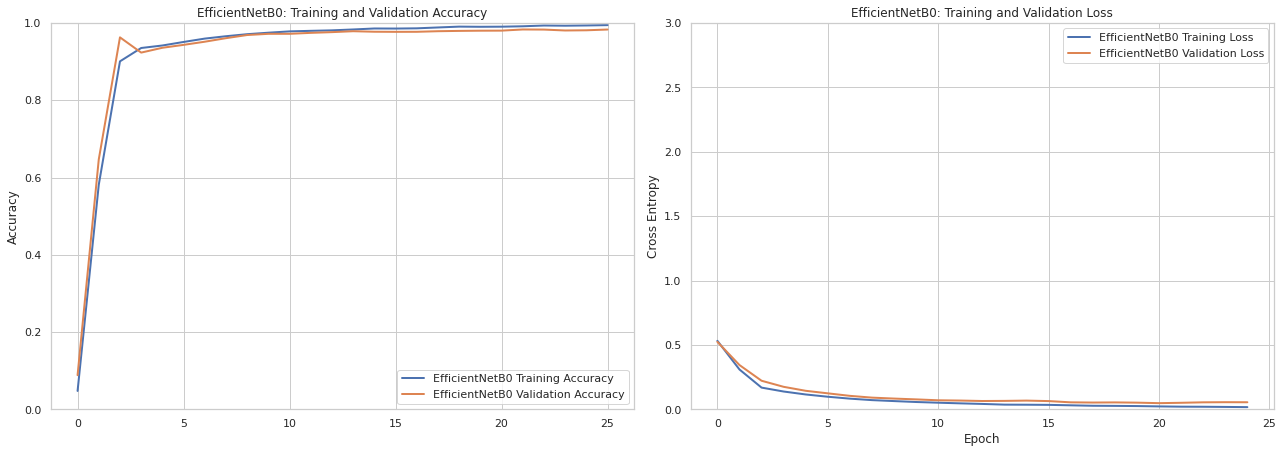

In [36]:
# EfficientNetB0 History
acc_effnet = [0.] + history_efficientnet.history['accuracy']
val_acc_effnet = [0.] + history_efficientnet.history['val_accuracy']
loss_effnet = history_efficientnet.history['loss']
val_loss_effnet = history_efficientnet.history['val_loss']

# Smooth the curves
acc_smooth_effnet = savgol_filter(acc_effnet, window_length=5, polyorder=2)
val_acc_smooth_effnet = savgol_filter(val_acc_effnet, window_length=5, polyorder=2)
loss_smooth_effnet = savgol_filter(loss_effnet, window_length=5, polyorder=2)
val_loss_smooth_effnet = savgol_filter(val_loss_effnet, window_length=5, polyorder=2)

# Plotting
plt.figure(figsize=(18, 12))

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(acc_smooth_effnet, label='EfficientNetB0 Training Accuracy', linewidth=2)
plt.plot(val_acc_smooth_effnet, label='EfficientNetB0 Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('EfficientNetB0: Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(loss_smooth_effnet, label='EfficientNetB0 Training Loss', linewidth=2)
plt.plot(val_loss_smooth_effnet, label='EfficientNetB0 Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('EfficientNetB0: Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
